In [2]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [3]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.20,   # 20% test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Split 10% of the training set as validation
val_fraction = 0.10  # 10% of training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=val_fraction,
    random_state=42,
    stratify=y_train_full
)
# === Step 11: Encode labels ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# === Step 12: Convert to tensors for PyTorch ===
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(np.array(X_val), dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# === Step 13: Summary ===
print("\n✅ Split Summary:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X_filtered):.2%})")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X_filtered):.2%})")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X_filtered):.2%})")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\n✅ Tensors ready for training:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")


Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Split Summary:
Train: 11695 samples (72.00%)
Validation: 1300 samples (8.00%)
Test: 3249 samples (20.00%)

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    6529
MI      1823
STTC    1728
CD      1230
HYP      385
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    726
MI      203
STTC    192
CD      136
HYP      43
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    1814
MI       506
STTC     480
CD       342
HYP      107
Name: count, dtype: int64

✅ Tensors ready for training:
X_train: torch.Size([11695, 1000, 12]), y_train: torch.Size([11695])
X_val: torch.Size([1300, 1000, 12]), y_val: torch.Size([1300])
X_test: torch.Size([3249, 1000, 12]), y_test: torch.Size([3249])


In [4]:
!pip install lightly


In [5]:
!pip install --upgrade lightly


/usr/local/lib/python3.11/dist-packages/lightly/models/moco.py:56: Warning: The high-level building block MoCo will be deprecated in version 1.3.0. Use low-level building blocks instead. See https://docs.lightly.ai/self-supervised-learning/lightly.models.html for more information
  warnings.warn(


Epoch [1/50] Train=4.5793 Val=4.3794
Epoch [2/50] Train=4.1855 Val=4.0555
Epoch [3/50] Train=3.9516 Val=3.8971
Epoch [4/50] Train=3.8215 Val=4.0324
Epoch [5/50] Train=3.7265 Val=3.7781
Epoch [6/50] Train=3.6536 Val=3.7169
Epoch [7/50] Train=3.5979 Val=3.6348
Epoch [8/50] Train=3.5625 Val=3.6034
Epoch [9/50] Train=3.5262 Val=3.5882
Epoch [10/50] Train=3.4918 Val=3.5515
Epoch [11/50] Train=3.4739 Val=3.4734
Epoch [12/50] Train=3.4356 Val=3.4314
Epoch [13/50] Train=3.4206 Val=3.4721
Epoch [14/50] Train=3.3974 Val=3.4031
Epoch [15/50] Train=3.3710 Val=3.5203
Epoch [16/50] Train=3.3624 Val=3.3812
Epoch [17/50] Train=3.3469 Val=3.3774
Epoch [18/50] Train=3.3245 Val=3.3536
Epoch [19/50] Train=3.2962 Val=3.3217
Epoch [20/50] Train=3.2833 Val=3.2744
Epoch [21/50] Train=3.2696 Val=3.2693
Epoch [22/50] Train=3.2527 Val=3.3071
Epoch [23/50] Train=3.2203 Val=3.2621
Epoch [24/50] Train=3.2056 Val=3.3793
Epoch [25/50] Train=3.1829 Val=3.2543
Epoch [26/50] Train=3.1674 Val=3.2485
Epoch [27/50] Train=3

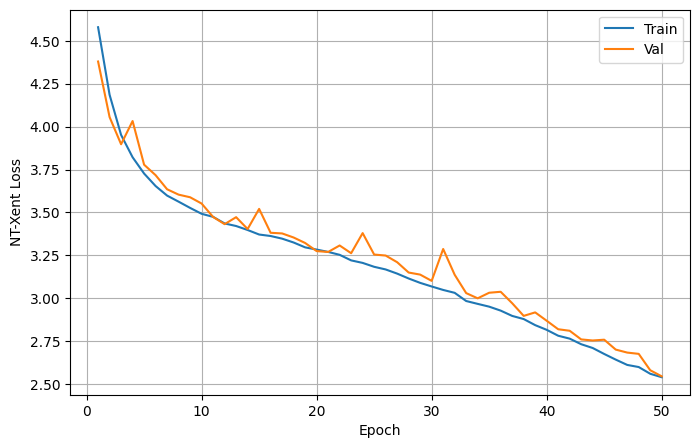

✅ MoCo pretraining completed & saved


In [6]:
# =========================================================
# MoCo v2 Pretraining (ResNet-1D) for ECG using Lightly
# =========================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightly.models import MoCo
from lightly.loss import NTXentLoss

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3

OUT_DIR = "moco_ckpts"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================================================
# ECG AUGMENTATION
# =========================================================
class ECGTransform:
    def __init__(self, jitter=0.03, scale=0.1, mask_prob=0.05, drop_channel_prob=0.1):
        self.jitter = jitter
        self.scale = scale
        self.mask_prob = mask_prob
        self.drop_channel_prob = drop_channel_prob

    def jitter_fn(self, x):
        return x + torch.randn_like(x) * self.jitter

    def scale_fn(self, x):
        return x * (1 + self.scale * torch.randn(1).item())

    def mask_fn(self, x):
        return x * (~(torch.rand_like(x) < self.mask_prob))

    def channel_dropout_fn(self, x):
        mask = (torch.rand(x.size(0)) < self.drop_channel_prob).float().unsqueeze(1)
        return x * (1 - mask)

    def __call__(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)

        if x.shape[0] != 12:
            x = x[:12]

        x1, x2 = x.clone(), x.clone()
        for fn in [self.jitter_fn, self.scale_fn, self.mask_fn, self.channel_dropout_fn]:
            x1 = fn(x1)
            x2 = fn(x2)

        return x1, x2


# =========================================================
# DATASET
# =========================================================
class ECGDataset(Dataset):
    def __init__(self, signals, transform):
        self.signals = signals
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]  # (C, T)
        return self.transform(x)


# =========================================================
# RESNET-1D BACKBONE
# =========================================================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)
        return self.relu(out)


class ResNet1D(nn.Module):
    def __init__(self, layers=[3,4,6,3], in_channels=12, feat_dim=256):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv1d(in_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(3, 2, 1)

        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, feat_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return nn.functional.normalize(self.fc(x), dim=1)


# =========================================================
# LOAD DATA (YOU MUST PROVIDE THESE)
# X_train_tensor, X_val_tensor : (N, 12, T)
# =========================================================
train_dataset = ECGDataset(X_train_tensor.numpy(), ECGTransform())
val_dataset   = ECGDataset(X_val_tensor.numpy(), ECGTransform())

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

# =========================================================
# MOCO MODEL
# =========================================================
backbone = ResNet1D()
moco_model = MoCo(backbone, num_ftrs=256).to(DEVICE)

moco_model.projector = nn.Sequential(
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256)
).to(DEVICE)

criterion = NTXentLoss(temperature=0.2)
optimizer = optim.Adam(moco_model.parameters(), lr=LR)

# =========================================================
# TRAINING LOOP
# =========================================================
history = {"epoch": [], "train_loss": [], "val_loss": []}

for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    moco_model.train()
    train_loss, seen = 0.0, 0

    for x1, x2 in train_loader:
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)

        q, k = moco_model(x1, x2)
        loss = criterion(q, k)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x1.size(0)
        seen += x1.size(0)

    avg_train = train_loss / seen

    # ---------- VAL ----------
    moco_model.eval()
    val_loss, seen = 0.0, 0

    with torch.no_grad():
        for x1, x2 in val_loader:
            x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
            q, k = moco_model(x1, x2)
            loss = criterion(q, k)
            val_loss += loss.item() * x1.size(0)
            seen += x1.size(0)

    avg_val = val_loss / seen

    # ---------- LOG ----------
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train)
    history["val_loss"].append(avg_val)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train={avg_train:.4f} Val={avg_val:.4f}")

    # ---------- SAVE CKPT ----------
    torch.save({
        "epoch": epoch + 1,
        "moco_state": moco_model.state_dict(),
        "backbone_state": moco_model.backbone.state_dict(),
        "optimizer": optimizer.state_dict()
    }, f"{OUT_DIR}/moco_epoch_{epoch+1}.pth")

# =========================================================
# SAVE HISTORY
# =========================================================
df = pd.DataFrame(history)
df.to_csv(f"{OUT_DIR}/moco_loss_history.csv", index=False)

plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["train_loss"], label="Train")
plt.plot(history["epoch"], history["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.legend()
plt.grid()
plt.savefig(f"{OUT_DIR}/moco_train_val_loss.png", dpi=150)
plt.show()

print("✅ MoCo pretraining completed & saved")


In [13]:
# =========================================================
# MoCo Downstream Classification (fixed)
# =========================================================

import os, time, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

OUT_DIR = "moco_downstream"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD PRETRAINED MoCo BACKBONE ------------------
# Make sure ResNet1D defined correctly
resnet1d = ResNet1D(layers=[3,4,6,3], in_channels=12, feat_dim=256)
ckpt = torch.load("moco_ckpts/moco_epoch_50.pth", map_location=DEVICE)
resnet1d.load_state_dict(ckpt["backbone_state"])
resnet1d.to(DEVICE)
resnet1d.eval()

# ------------------ FEATURE EXTRACTION ------------------
@torch.no_grad()
def extract_features(X_tensor, batch_size=64):
    feats = []
    for i in range(0, len(X_tensor), batch_size):
        x = X_tensor[i:i+batch_size]
        # Ensure shape is (B, C, T)
        if x.shape[1] != 12:
            x = x.permute(0, 2, 1)
        x = x.to(DEVICE)
        f = resnet1d(x)
        feats.append(f.cpu().numpy())
    return np.vstack(feats)

print("Extracting features...")
t0 = time.time()

# X_all_tensor = your ECG tensor (N, T, 12) or (N, 12, T)
# y_all_tensor = labels tensor (N,)
X_feat = extract_features(X_all_tensor)
y_raw  = y_all_tensor.numpy()

print("Features shape:", X_feat.shape, "time:", time.time()-t0)

# ------------------ SAVE RAW FEATURES ------------------
np.save(os.path.join(OUT_DIR, "features.npy"), X_feat)
pd.Series(y_raw).to_csv(os.path.join(OUT_DIR, "labels.csv"), index=False)

# ------------------ LABEL ENCODING ------------------
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]  # fix int issue
n_classes = len(class_names)

# ------------------ TRAIN/TEST SPLIT ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# ------------------ SCALE FEATURES ------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

# ------------------ CLASSIFIERS ------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial'),
    "SVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=200)
}

results = []

for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_s, y_train)

    y_pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)

    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # ROC AUC
    macro_auc = np.nan
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test_s)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        macro_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")

        if name in ["LogisticRegression", "SVM"]:
            plt.figure(figsize=(8,6))
            for i, cname in enumerate(class_names):
                if y_test_bin[:, i].sum() == 0: continue
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                plt.plot(fpr, tpr, label=f"{cname}")
            plt.plot([0,1],[0,1],'k--')
            plt.title(f"{name} ROC (macro AUC={macro_auc:.3f})")
            plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.legend(fontsize="small")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"roc_{name.lower()}.png"), dpi=150)
            plt.close()

    # save model
    joblib.dump(clf, os.path.join(OUT_DIR, f"{name.lower()}.joblib"))

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_auc": macro_auc,
        "train_size": len(X_train),
        "test_size": len(X_test)
    })

# ------------------ SAVE SUMMARY ------------------
summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(OUT_DIR, "summary.csv"), index=False)

print("\n✅ MoCo downstream evaluation completed")
print(summary_df)
print("\nSaved everything to:", OUT_DIR)


Extracting features...
Features shape: (16244, 256) time: 2.960500717163086

Training LogisticRegression...
Accuracy: 0.6143428747306864
              precision    recall  f1-score   support

           0       0.66      0.23      0.34       342
           1       0.57      0.04      0.07       107
           2       0.53      0.16      0.24       506
           3       0.63      0.95      0.76      1814
           4       0.45      0.22      0.29       480

    accuracy                           0.61      3249
   macro avg       0.57      0.32      0.34      3249
weighted avg       0.59      0.61      0.54      3249


Training SVM...
Accuracy: 0.5881809787626963
              precision    recall  f1-score   support

           0       0.73      0.18      0.28       342
           1       0.00      0.00      0.00       107
           2       0.55      0.02      0.04       506
           3       0.59      0.99      0.73      1814
           4       0.55      0.11      0.18       480

  

Feature shape: (16244, 256)


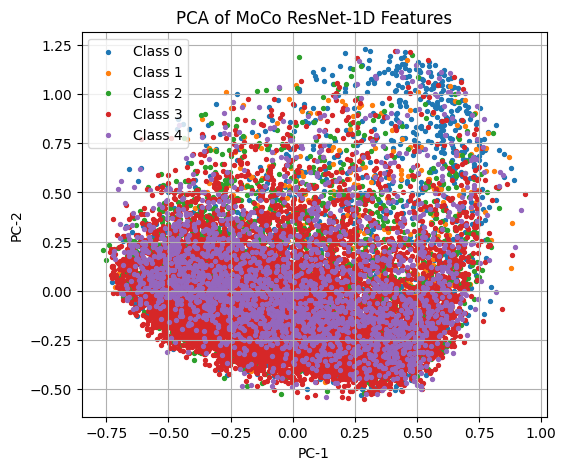

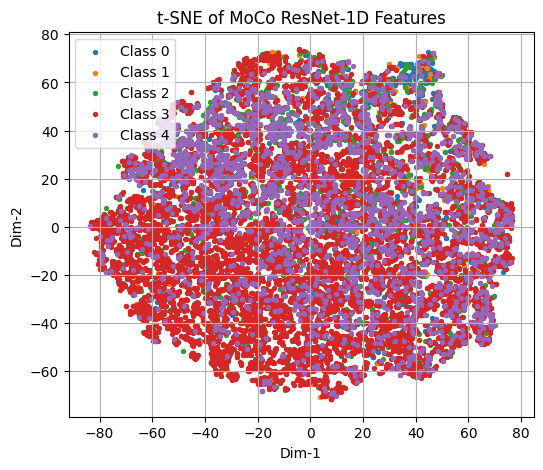

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import numpy as np

# =========================
# Features and labels
# =========================
# Use extracted MoCo features and labels
X_feat = X_feat  # (N, 256) features from MoCo
y_feat = y_raw   # (N,) labels

print("Feature shape:", X_feat.shape)

# Get unique classes
classes = np.unique(y_feat)
num_classes = len(classes)
cmap = ListedColormap(plt.get_cmap("tab10").colors[:num_classes])

# =========================
# PCA 2D
# =========================
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_feat)

plt.figure(figsize=(6,5))
for idx, cls in enumerate(classes):
    mask = y_feat == cls
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], s=8, label=f"Class {cls}", color=cmap(idx))
plt.title("PCA of MoCo ResNet-1D Features")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# PCA -> t-SNE
# =========================
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_feat)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca_50)

plt.figure(figsize=(6,5))
for idx, cls in enumerate(classes):
    mask = y_feat == cls
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=8, label=f"Class {cls}", color=cmap(idx))
plt.title("t-SNE of MoCo ResNet-1D Features")
plt.xlabel("Dim-1")
plt.ylabel("Dim-2")
plt.legend()
plt.grid(True)
plt.show()
